In [2]:
import pandas as pd
df = pd.read_csv('./train_labels.csv')
df.sample(3)

,Unnamed: 0,row_id,tomo_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors
463,463,248,tomo_53e048,190.0,666.0,542.0,300,960,928,13.1,1
645,645,468,tomo_a5ac23,171.0,438.0,138.0,300,959,928,15.6,2
109,109,487,tomo_ab78d0,-1.0,-1.0,-1.0,800,928,960,13.1,0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import glob
import sys

def select_tomo_ids(df, number_of_slices=[300], number_of_motors=[0, 1], y_shape_range=(924, 960), x_shape_range=(924, 960)) -> pd.Series:
    '''
    Return the list of the tomo_ids obtained by filtering the DataFrame base on the given parameters

            Parameters:
                    df (pd.Dataframe): the dataset to filter
                    number_of_slices (list:int): number of slices per tomogram
                    max_number_of_motors (list:int): max number of motors
                    y_shape_range(tuple:int): tuple of the (min, max) y size of pictures
                    x_shape_range(tuple:int): tuple of the (min, max) x size of pictures

            Returns:
                    pd.Series: pandas Series of the tomo_ids corresponding to the filter
    '''
    df = df[(df['Array_shape_axis_1'] >= y_shape_range[0]) & (df['Array_shape_axis_2'] <= y_shape_range[1])]
    df = df[(df['Array_shape_axis_1'] >= x_shape_range[0]) & (df['Array_shape_axis_2'] <= x_shape_range[1])]
    df = df[(df['Array_shape_axis_0'].isin(number_of_slices)) & (df['Number_of_motors'].isin(number_of_motors))]


    return df.tomo_id


def selection_images_labels(df, dir_images, num_slices=[300], num_motors=[1]):

    ''''
    function to return the path to the selected images (which type, which tomos, how many motors,
    shape of the images)
    Parameters:
    ----------
    df = database (train)
    dir_images(str) = directory with the images we want to feed to the model
    num_slices, num_motors, y_shape_range, x_shape_range = params for the select_tomo_ids function

    Returns:
    -------
    filtered_image_paths (list or np.array): List of image paths.

    labels (np.array or list): Corresponding labels.
    '''

   # Step 1: Filter tomos
    tomo_ids = select_tomo_ids(df, number_of_slices=num_slices, number_of_motors=num_motors)
    df_select = df[df['tomo_id'].isin(tomo_ids)].copy()

    # Step 2: Set up labels
    df_select['motor_coord'] = df_select.apply(lambda row: (row['Motor_axis_2'], row['Motor_axis_1']), axis=1)

    # Step 3: Load all images
    dir_mean_image = f'./drive/MyDrive/{dir_images}'
    all_images = glob.glob(os.path.join(dir_mean_image, '**', '*.jpg'), recursive=True)

    print(f"Found {len(all_images)} images in {dir_mean_image}")

    # Step 4: Match images using substring matching
    filtered_image_paths = []
    labels = []

    for _, row in df_select.iterrows():
        tomo_id = row['tomo_id']
        matched = [p for p in all_images if tomo_id in os.path.basename(p)]

        if matched:
            filtered_image_paths.append(matched[0])  # If multiple, take the first
            labels.append(row['motor_coord'])
        else:
            print(f"⚠️ No image found for tomo_id: {tomo_id}")

    print(f"Matched {len(filtered_image_paths)} image-label pairs")

    labels = np.array(labels, dtype=np.float32)
    return filtered_image_paths, labels


# Define image reading function
def read_img_jpg(path, label):
    """
    Reads a JPEG image from a file path, decodes it as a grayscale image (1 channel),
    normalizes pixel values to the range [0, 1], and returns it along with its label.

    Parameters:
    ----------
    path : tf.Tensor
        A scalar string tensor representing the file path to the JPEG image.

    label : tf.Tensor or any
        The label associated with the image (e.g., coordinates or class ID).

    Returns:
    -------
    img : tf.Tensor
        A 3D float32 tensor of shape (height, width, 1) representing the normalized image.

    label : same as input
        The original label passed in, unchanged.
    """
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.cast(img, tf.float32) / 255.0  # normalize to [0, 1]
    return img, label



def batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=False,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42
):
    """
    Load images and labels as tf.data.Dataset, optionally shuffle and batch,
    and optionally split into train/val/test datasets.

    Parameters:
    -----------
    read_img_jpg : function
        Function to load and preprocess image from path.

    filtered_image_paths : list or np.array
        List of image paths.

    labels : np.array or list
        Corresponding labels.

    shuffle : bool, default=True
        Whether to shuffle the dataset.

    batch_size : int, default=32
        Batch size.

    split : bool, default=False
        Whether to split dataset into train/val/test.

    val_fraction : float, default=0.2
        Fraction of data for validation.

    test_fraction : float, default=0.2
        Fraction of data for testing.

    seed : int, default=42
        Random seed for shuffling.

    Returns:
    --------
    If split=False:
        dataset : tf.data.Dataset
            Dataset with (image, label) pairs, batched and optionally shuffled.

    If split=True:
        train_ds, val_ds, test_ds : tf.data.Dataset
            The three splits, all batched and shuffled as specified.
    """

    dataset_size = len(filtered_image_paths)
    # Combine and optionally shuffle the data as a list of tuples
    data = list(zip(filtered_image_paths, labels))
    if shuffle:
        rng = np.random.default_rng(seed)
        rng.shuffle(data)

    # Unzip the shuffled data back
    filtered_image_paths, labels = zip(*data)

    # Convert back to lists or arrays
    filtered_image_paths = list(filtered_image_paths)
    labels = list(labels)

    if split:
        # Compute sizes
        val_size = int(val_fraction * dataset_size)
        test_size = int(test_fraction * dataset_size)
        train_size = dataset_size - val_size - test_size

        # Split into slices
        test_paths = filtered_image_paths[:test_size]
        test_labels = labels[:test_size]

        val_paths = filtered_image_paths[test_size:test_size + val_size]
        val_labels = labels[test_size:test_size + val_size]

        train_paths = filtered_image_paths[test_size + val_size:]
        train_labels = labels[test_size + val_size:]

        # Create tf.data.Dataset for each
        train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(read_img_jpg).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(read_img_jpg).batch(batch_size)
        test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(read_img_jpg).batch(batch_size)

        return train_ds, val_ds, test_ds #, test_paths, test_labels

    else:
        # Single dataset
        dataset = tf.data.Dataset.from_tensor_slices((filtered_image_paths, labels))
        dataset = dataset.map(read_img_jpg).batch(batch_size)
        return dataset, filtered_image_paths, labels


def plot_history_regression(history, xlims=None, ylims=None):
    '''
    Function to plot learning curves for a regression task
    Parameters:
        history: output from a model.fit
        xlims,ylims (tuple of float, optional): limits for x and y axes, if not
                                                provided are defined as
                                                (0,max(epochs)), (0,max(loss))
    '''
    if xlims is None:
        xlims = (0, max(history.epoch))
    if ylims is None:
        ylims = (0, max(history.history['loss']))
    print(xlims,ylims)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].set_ylim(ylims)
    ax[0].set_xlim(xlims)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    ax[1].set_title('euclidean loss')
    ax[1].plot(history.epoch, history.history["euclidean_loss"], label="Train euclidean loss")
    ax[1].plot(history.epoch, history.history["val_euclidean_loss"], label="Validation euclidean loss")
    ax[1].set_ylim(ylims)
    ax[1].set_xlim(xlims)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('euclidean loss')
    ax[0].legend()
    ax[1].legend()



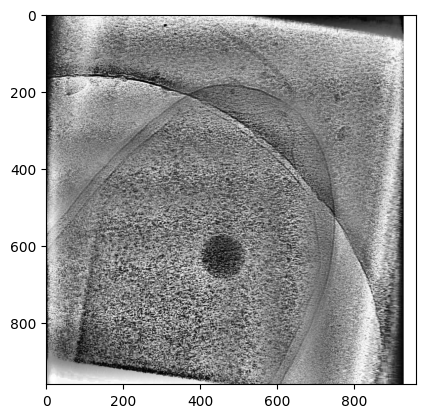

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as img

tomo_mean = img.imread(f'./drive/MyDrive/adaptequal_1_padded/tomo_2c9da1.jpg')

plt.imshow(tomo_mean, cmap='gray')

In [7]:
all_slices_number = df['Array_shape_axis_0'].unique()

filtered_image_paths,labels = selection_images_labels(df, 'adaptequal_1_padded', num_slices=list(all_slices_number), num_motors=[1])

train_ds, val_ds, test_ds = batches_images_ram(
    read_img_jpg,
    filtered_image_paths,
    labels,
    shuffle=True,
    batch_size=32,
    split=True,
    val_fraction=0.2,
    test_fraction=0.2,
    seed=42)

Found 648 images in ./drive/MyDrive/adaptequal_1_padded
Matched 313 image-label pairs


In [102]:
from keras import Sequential, Input, layers

def initiate_model():

    model = Sequential()
     ### First Convolution & MaxPooling
    model.add(Input(shape=(960, 960, 1)))
    model.add(layers.Resizing(224,224, interpolation="bilinear"))
    model.add(layers.Conv2D(32, (4,4), activation = 'relu', padding='same'))
    model.add(layers.Conv2D(32, (4,4), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same'))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(128, (2,2), activation = 'relu', padding='same'))
    model.add(layers.Conv2D(128, (2,2), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(256, (2,2), activation = 'relu', padding='same'))
    model.add(layers.Conv2D(256, (2,2), activation = 'relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.2))

    ## Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(126,activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(16,activation='relu'))
    model.add(layers.Dropout(0.1))

    model.add(layers.Dense(2,activation='linear'))

    return model

In [104]:
import tensorflow as tf

def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_pred - y_true, axis=1))

def compile_model(model):
    ### Model compilation
    model.compile(loss=euclidean_loss,optimizer='adam',metrics=[euclidean_loss])
    return model

In [105]:
model = initiate_model()
model = compile_model(model)
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_20 (Resizing)          │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 224, 224, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 224, 224, 32)   │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 74, 74, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 24, 24, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 24, 24, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 12, 12, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_80 (Conv2D)              │ (None, 12, 12, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 126)            │     1,161,342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 126)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 16)             │         2,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,728,080 (6.59 MB)

 Trainable params: 1,728,080 (6.59 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(train_ds, validation_data=val_ds, epochs=150)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - euclidean_loss: 658.0977 - loss: 658.5834 - val_euclidean_loss: 421.5989 - val_loss: 422.6866
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - euclidean_loss: 459.5117 - loss: 459.8748 - val_euclidean_loss: 325.8536 - val_loss: 327.3912
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - euclidean_loss: 336.3190 - loss: 336.1473 - val_euclidean_loss: 415.8155 - val_loss: 417.4678
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - euclidean_loss: 289.2675 - loss: 289.2058 - val_euclidean_loss: 436.6383 - val_loss: 438.2740
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - euclidean_loss: 311.2289 - loss: 311.1260 - val_euclidean_loss: 348.9114 - val_loss: 350.4821
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 381ms/step - euclidean_loss: 294.4810 - loss: 294.4679 - val_euclidean_loss: 329.0459 - val_loss: 330.6004
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - euclidean_loss: 304.0288 - loss: 304.2086 - val_euclidean_loss: 328

(0, 149) (0, 642.4913940429688)


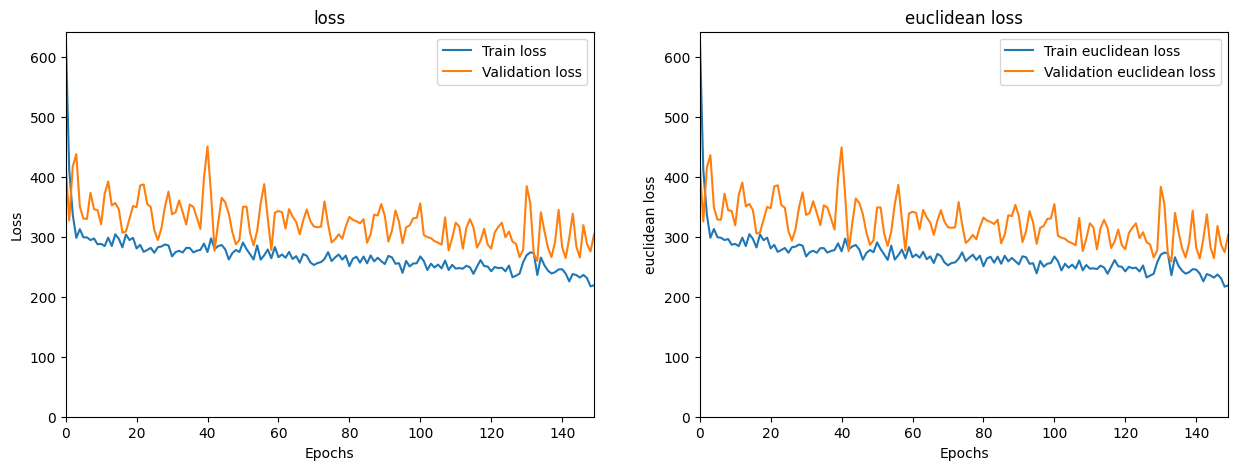

In [107]:
plot_history_regression(history)

In [108]:
model.evaluate(test_ds)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - euclidean_loss: 258.1500 - loss: 258.0633


[259.3628845214844, 259.4928283691406]

In [89]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# Fonction de perte personnalisée (distance euclidienne)
def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

# Nombre de keypoints
NUM_KEYPOINTS = 1

# Entrée image N&B
input_tensor = Input(shape=(960, 960, 1), name="grayscale_input")
x = layers.Resizing(224, 224) (input_tensor)
# Convertir en 3 canaux pour VGG16
x = layers.Conv2D(3, (3, 3), padding='same')(x)  # (960, 960, 3)

# Import du backbone VGG16 sans top layers
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False  # gel du backbone

# Extraction de features
x = vgg(x)
x = layers.GlobalAveragePooling2D()(x)  # réduit à (None, nb_features)

# Densely connected layers
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Prédiction des keypoints (2 coordonnées par point)
out = layers.Dense(NUM_KEYPOINTS * 2, activation='linear', name="keypoints")(x)

# Création du modèle
model = Model(inputs=input_tensor, outputs=out)

# Compilation
model.compile(
    loss=euclidean_loss,
    optimizer='adam',
    metrics=[euclidean_loss]
)

# Callback
es = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entraînement
history = model.fit(train_ds, validation_data=val_ds, epochs=150, callbacks=[es])


Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - euclidean_loss: 676.3448 - loss: 676.1802 - val_euclidean_loss: 766.1588 - val_loss: 767.9669
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - euclidean_loss: 673.1078 - loss: 672.9439 - val_euclidean_loss: 763.0446 - val_loss: 764.8533
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step - euclidean_loss: 670.5580 - loss: 670.3942 - val_euclidean_loss: 759.6191 - val_loss: 761.4291
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - euclidean_loss: 666.2583 - loss: 666.0959 - val_euclidean_loss: 755.3215 - val_loss: 757.1328
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 606ms/step - euclidean_loss: 661.8817 - loss: 661.7146 - val_euclidean_loss: 749.9824 - val_loss: 751.7950
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - euclidean_loss: 656.8734 - loss: 656.7193 - val_euclidean_loss: 743.3108 - val_loss: 745.1245
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - euclidean_loss: 649.8692 - loss: 649.7241 - val_euclidean_loss: 735

(0, 46) (0, 689.224853515625)


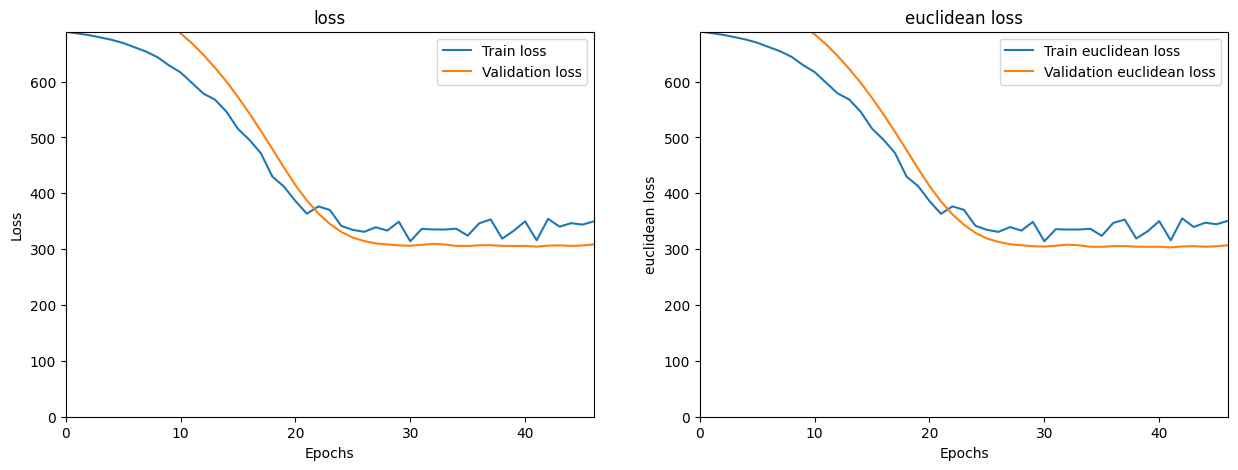

In [90]:
plot_history_regression(history)

In [121]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

NUM_KEYPOINTS = 1  # change si tu veux plusieurs points
IMG_SIZE = 224

input_tensor = Input(shape=(960, 960, 1), name="grayscale_input")

# Resize et conversion N&B -> RGB
x = layers.Resizing(IMG_SIZE, IMG_SIZE)(input_tensor)
x = layers.Conv2D(3, (3, 3), padding='same')(x)

# Backbone MobileNetV2 (plus léger que VGG16)
backbone = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
backbone.trainable = True  # gel du backbone

for layer in backbone.layers[:-2]:
    layer.trainable = False

x = backbone(x)

# Flatten + Dense
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Sortie des keypoints
out = layers.Dense(NUM_KEYPOINTS * 2, activation='linear', name="keypoints")(x)

model = Model(inputs=input_tensor, outputs=out)
model.compile(optimizer='adam', loss=euclidean_loss, metrics=[euclidean_loss])

# Callback early stopping
es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

# Entraînement
history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[es])


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - euclidean_loss: 675.6968 - loss: 675.5366 - val_euclidean_loss: 764.9885 - val_loss: 766.7969
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 306ms/step - euclidean_loss: 670.2272 - loss: 670.0697 - val_euclidean_loss: 758.0281 - val_loss: 759.8374
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - euclidean_loss: 661.8551 - loss: 661.7009 - val_euclidean_loss: 748.5464 - val_loss: 750.3563
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - euclidean_loss: 650.7073 - loss: 650.5641 - val_euclidean_loss: 736.0953 - val_loss: 737.9045
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - euclidean_loss: 634.9286 - loss: 634.7961 - val_euclidean_loss: 719.8334 - val_loss: 721.6390
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 308ms/step - euclidean_loss: 612.5967 - loss: 612.4526 - val_euclidean_loss: 698.7332 - val_loss: 700.5304
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - euclidean_loss: 587.8918 - loss: 587.7661 - val_euclidean_loss: 672

(0, 39) (0, 688.2825927734375)


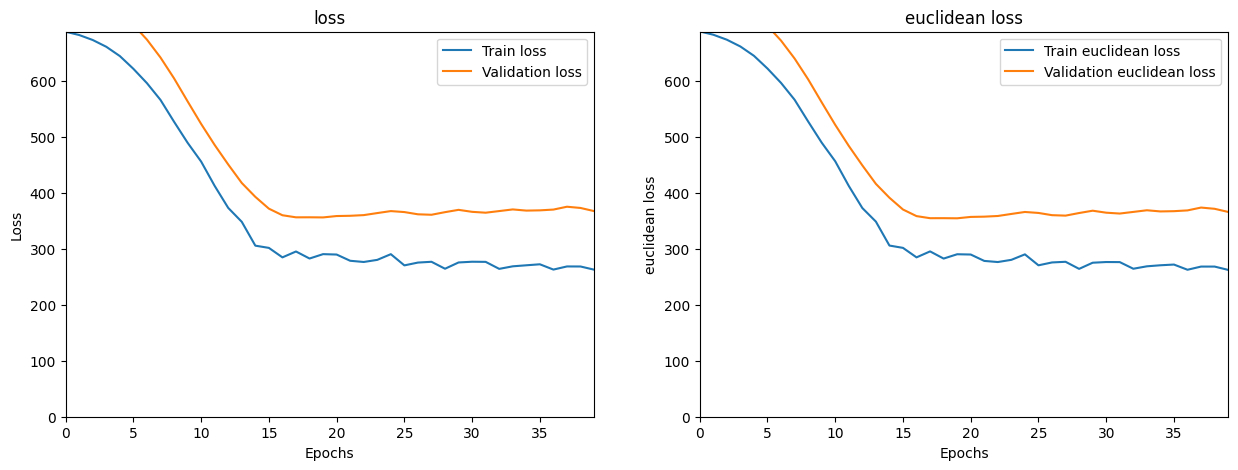

In [122]:
plot_history_regression(history)

In [124]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping

def euclidean_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)))

NUM_KEYPOINTS = 1  # change si tu veux plusieurs points
IMG_SIZE = 224

input_tensor = Input(shape=(960, 960, 1), name="grayscale_input")

# Resize et conversion N&B -> RGB
x = layers.Resizing(IMG_SIZE, IMG_SIZE)(input_tensor)
x = layers.Conv2D(3, (3, 3), padding='same')(x)

# Backbone MobileNetV2 (plus léger que VGG16)
backbone = EfficientNetB3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
backbone.trainable = True  # gel du backbone

for layer in backbone.layers[:-2]:
    layer.trainable = False

x = backbone(x)

# Flatten + Dense
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Sortie des keypoints
out = layers.Dense(NUM_KEYPOINTS * 2, activation='linear', name="keypoints")(x)

model = Model(inputs=input_tensor, outputs=out)
model.compile(optimizer='adam', loss=euclidean_loss, metrics=[euclidean_loss])

# Callback early stopping
es = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=1)

# Entraînement
history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=[es])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 133s 17s/step - euclidean_loss: 675.1486 - loss: 674.9910 - val_euclidean_loss: 768.7471 - val_loss: 770.5543
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 344ms/step - euclidean_loss: 669.5966 - loss: 669.4411 - val_euclidean_loss: 768.1869 - val_loss: 769.9940
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - euclidean_loss: 662.2412 - loss: 662.0862 - val_euclidean_loss: 767.9810 - val_loss: 769.7880
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step - euclidean_loss: 653.8891 - loss: 653.7523 - val_euclidean_loss: 767.8076 - val_loss: 769.6146
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - euclidean_loss: 641.9743 - loss: 641.8342 - val_euclidean_loss: 767.5348 - val_loss: 769.3418
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 493ms/step - euclidean_loss: 626.2907 - loss: 626.1366 - val_euclidean_loss: 767.2230 - val_loss: 769.0300
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - euclidean_los

(0, 130) (0, 687.564208984375)


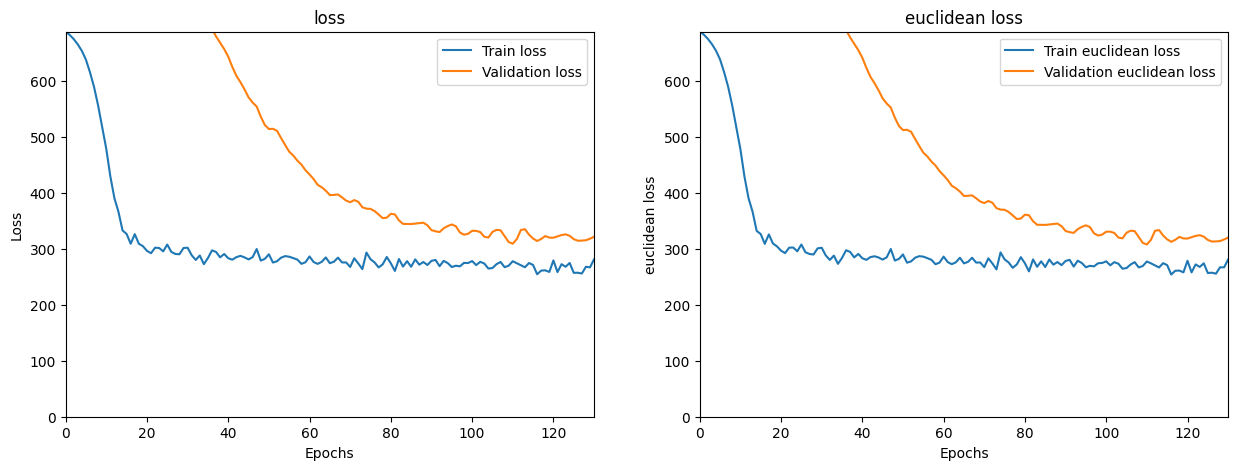

In [125]:
plot_history_regression(history)